# Demonstration of MUSE

This is a demonstration of MUSE analysis on a multi-modality simulated data.

Altschuler & Wu Lab 2020.

Software provided as is under MIT License.

## Import packages

In [1]:
import muse_sc as muse
import simulation_tool.multi_modal_simulation as simulation
import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mofapy2.run.entry_point import entry_point
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

np.random.seed(0)

## Generate simulation data

Simulation parameters

In [2]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1  
sigma_2 = 0.1  
decay_coef_1 = 0.5 
decay_coef_2 = 0.1
merge_prob = 0.7

Use simulation tool to generate multi-modality data

In [3]:
data = simulation.multi_modal_simulator(num_cluster, sample_size,
                                        observed_data_dim, observed_data_dim,
                                        latent_code_dim,
                                        sigma_1, sigma_2,
                                        decay_coef_1, decay_coef_2,
                                        merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_true = data['true_cluster']

## Analyses based on single modality

Learn features from single modality

In [4]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)

Perform clustering using PhenoGraph

In [5]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2516934871673584 seconds
Jaccard graph constructed in 0.6403088569641113 seconds
Wrote graph to binary file in 0.18546199798583984 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.568402
After 2 runs, maximum modularity is Q = 0.569417
Louvain completed 22 runs in 0.9927647113800049 seconds
PhenoGraph complete in 2.1061463356018066 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22819900512695312 seconds
Jaccard graph constructed in 0.7026166915893555 seconds
Wrote graph to binary file in 0.08325743675231934 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.642119
Louvain completed 21 runs in 0.7062313556671143 seconds
PhenoGraph complete in 1.7326655387878418 seconds


## Combined analysis using MUSE

MUSE learns the joint latent representation

In [6]:
muse_feature, reconstruct_x, reconstruct_y, \
latent_x, latent_y = muse.muse_fit_predict(data_a,
                                           data_b,
                                           view_a_label,
                                           view_b_label,
                                           latent_dim=100,
                                           n_epochs=500,
                                           lambda_regul=5,
                                           lambda_super=5)

MUSE initialization
epoch: 0, 	 total loss: 1896.05029,	 reconstruction loss: 894.82202,	 sparse penalty: 200.24567
epoch: 50, 	 total loss: 1100.97180,	 reconstruction loss: 154.52422,	 sparse penalty: 189.28952
epoch: 0, 	 total loss: 1091.17017,	 reconstruction loss: 154.53313,	 sparse penalty: 178.21674,	 x triplet: 4.41087,	 y triplet: 4.69979
epoch: 50, 	 total loss: 1027.07056,	 reconstruction loss: 154.44313,	 sparse penalty: 167.45271,	 x triplet: 3.35271,	 y triplet: 3.72008
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22855544090270996 seconds
Jaccard graph constructed in 2.007232427597046 seconds
Wrote graph to binary file in 0.3071739673614502 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.84434
Louvain completed 21 runs in 1.5607476234436035 seconds
PhenoGraph complete in 4.117685317993164 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors

PhenoGraph clustering

In [7]:
muse_label, _, _ = phenograph.cluster(muse_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12968778610229492 seconds
Jaccard graph constructed in 1.9239263534545898 seconds
Wrote graph to binary file in 0.1208949089050293 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.897946
Louvain completed 21 runs in 1.6111509799957275 seconds
PhenoGraph complete in 3.8030946254730225 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

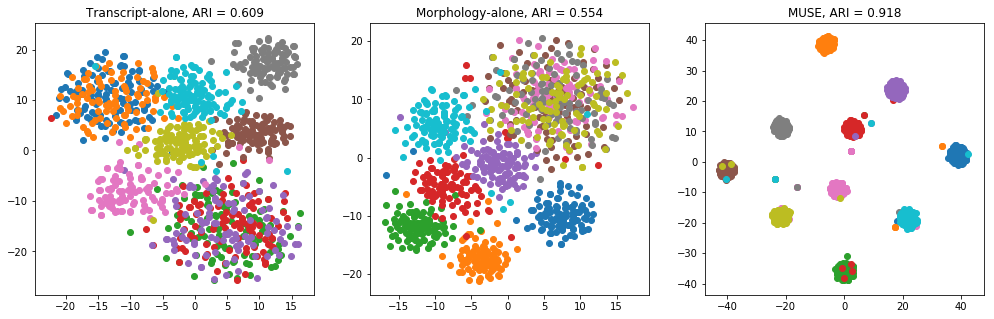

In [8]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Transcript-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(1, 3, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Morphology-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(1, 3, 3)
X_embedded = TSNE(n_components=2).fit_transform(muse_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muse_label))